In [1]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict, load_metric

In [2]:
root_dir = 'dataset'
dataset = load_dataset("imagefolder", data_dir=root_dir)

Resolving data files:   0%|          | 0/718 [00:00<?, ?it/s]

In [3]:
dataset = dataset['train'].train_test_split(test_size=0.3, stratify_by_column="label")  # 70% train, 30% test
dataset_test = dataset['test'].train_test_split(test_size=0.5, stratify_by_column="label")  # 30% test --> 15% valid, 15% test
dataset = DatasetDict({
    'train': dataset['train'],
    'test': dataset_test['test'],
    'valid': dataset_test['train']
})

del dataset_test

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 502
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 108
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 108
    })
})


In [5]:
labels = dataset['train'].features['label']
print(labels)

ClassLabel(names=['grooming', 'normal', 'rearing'], id=None)


In [6]:
from PIL import Image
import torchvision.transforms as transforms

def transform(example_batch):
    # Define the desired image size
    desired_size = (640, 480)

    # Resize the images to the desired size
    resized_images = [transforms.Resize(desired_size)(x.convert("RGB")) for x in example_batch['image']]

    # Convert resized images to pixel values
    inputs = processor(resized_images, return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']

    return inputs

prepared_dataset = dataset.with_transform(transform)

c:\Users\schiv\anaconda3\envs\DEEPLABCUT\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [7]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

C:\Users\schiv\AppData\Local\Temp\ipykernel_28728\322555055.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy", trust_remote_code=True)


In [8]:
from transformers import AutoImageProcessor, ViTForImageClassification

model_name_or_path = 'google/vit-base-patch16-224-in21k'

processor = AutoImageProcessor.from_pretrained(model_name_or_path)
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels.names),
    id2label={str(i): c for i, c in enumerate(labels.names)},
    label2id={c: str(i) for i, c in enumerate(labels.names)},
    ignore_mismatched_sizes=True
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments

root_dir = "training/"  # Path where all config files and checkpoints will be saved
training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=200,
  logging_steps=1000,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

c:\Users\schiv\anaconda3\envs\DEEPLABCUT\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["valid"],
    tokenizer=processor,
)

In [11]:
import torch
import numpy as np

save_dir = 'model/'  # Define the path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 0/6400 [00:00<?, ?it/s]

c:\Users\schiv\anaconda3\envs\DEEPLABCUT\lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.6135157942771912, 'eval_accuracy': 0.7870370370370371, 'eval_runtime': 1.659, 'eval_samples_per_second': 65.1, 'eval_steps_per_second': 8.439, 'epoch': 1.0}


KeyboardInterrupt: 

In [12]:
metrics = trainer.evaluate(prepared_dataset['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

  0%|          | 0/14 [00:00<?, ?it/s]

{'eval_loss': 0.5035708546638489, 'eval_accuracy': 0.7962962962962963, 'eval_runtime': 1.8248, 'eval_samples_per_second': 59.186, 'eval_steps_per_second': 7.672, 'epoch': 1.44}
***** test metrics *****
  epoch                   =     1.4375
  eval_accuracy           =     0.7963
  eval_loss               =     0.5036
  eval_runtime            = 0:00:01.82
  eval_samples_per_second =     59.186
  eval_steps_per_second   =      7.672


  0%|          | 0/14 [00:00<?, ?it/s]

Recall for grooming: 0.56
Recall for normal: 0.96
Recall for rearing: 0.06


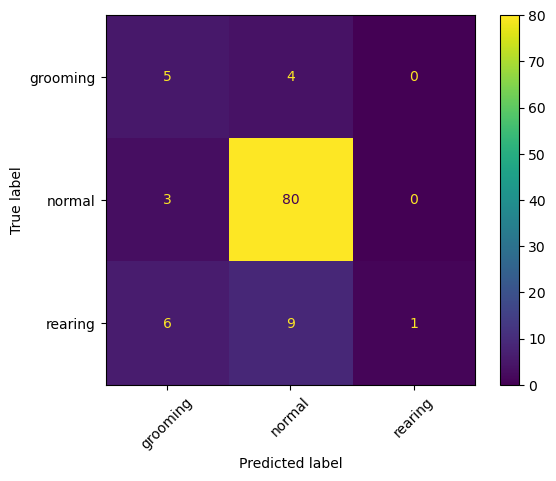

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

test_dataset = dataset['test'].with_transform(transform)
test_outputs = trainer.predict(test_dataset)

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_dataset.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

In [36]:
def getPrediction(image):
    model_name_or_path = 'google/vit-base-patch16-224-in21k'
    processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast=True)
    vit = ViTForImageClassification.from_pretrained(save_dir)
    model = pipeline('image-classification', model=vit, feature_extractor=processor, device=0)
    
    result = model(image)
    return result

In [37]:
import cv2
from transformers import pipeline
from PIL import Image

image = cv2.imread("dataset/grooming/img00639.png")
image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print(getPrediction(image))

[{'label': 'grooming', 'score': 0.9766818284988403}, {'label': 'normal', 'score': 0.18842917680740356}, {'label': 'rearing', 'score': 0.1351696401834488}]


In [26]:
import os

videopath = "videos/Test 1.mp4"
video = cv2.VideoCapture(videopath)
frame_count = 0
folder = videopath.split('.')[0]+'/'

while True:
    ret, frame = video.read()
    if not ret:
        break
    frame_count += 1
    if not os.path.exists(folder):
        os.mkdir(folder)
    image = videopath.split('.')[0]+'/'+str(frame_count)+'.jpg'
    cv2.imwrite(image, frame)
    if frame_count % 1000 == 0:
        print("Frame ", frame_count, " saved !")
video.release()

Frame  1000  saved !
Frame  2000  saved !
Frame  3000  saved !
Frame  4000  saved !
Frame  5000  saved !
Frame  6000  saved !
Frame  7000  saved !
Frame  8000  saved !
Frame  9000  saved !
Frame  10000  saved !
Frame  11000  saved !
Frame  12000  saved !
Frame  13000  saved !
Frame  14000  saved !
Frame  15000  saved !
Frame  16000  saved !
Frame  17000  saved !
Frame  18000  saved !
Frame  19000  saved !
Frame  20000  saved !
Frame  21000  saved !
Frame  22000  saved !
Frame  23000  saved !
Frame  24000  saved !
Frame  25000  saved !
Frame  26000  saved !
Frame  27000  saved !
Frame  28000  saved !
Frame  29000  saved !
Frame  30000  saved !
Frame  31000  saved !


Extraction of each frame of the videos to analyse them one by one with the ViT model

In [59]:
import glob

images = glob.glob(folder+"*.jpg")
timeOfVideo = 30
fps = (len(images)/timeOfVideo)/60
normal = 0
rearing = 0
grooming = 0
img_count = 0

for img in images:
    prediction = getPrediction(img)[0]['label']
    if prediction == 'normal':
        normal += 1
    elif prediction == 'rearing':
        rearing += 1
    else:
        grooming += 1
    img_count += 1
    if img_count % 1000 == 0:
        print(img_count, " frames done !")
    #For test only
    if img_count > fps*60:
        print("Temporary break !")
        break

c:\Users\schiv\anaconda3\envs\DEEPLABCUT\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1000  frames done !
Temporary break !


Analysis of a video frame by frame and counting the number of frames each behavior appears.

In [60]:
print(fps)
print("Number of frames done = ", img_count, "; in seconds = ", img_count/fps)
print("Time rearing = ", rearing/fps)
print("Time grooming = ", grooming/fps)
print("Time normal = ", normal/fps)

17.27111111111111
Number of frames done =  1037 ; in seconds =  60.04246011322697
Time rearing =  19.222851260936697
Time grooming =  2.7213072568193515
Time normal =  38.09830159547092


Converting the number of frames the behavior appears into seconds based on the frames per second of the video